# Prepping the final steps of PaddockTS

At this point, we can read in the Sentinel2 data plus indices, the Sentinel1 data, and the filtered paddock polygons, 
(and maybe some environmental data, but we're not going to worry about that in this script)

The next steps are, in order:
1. Generate paddock time series and save the raw versions in xarray form
2. perform interpolation and smoothing (include option for filtering of paddocks with too much missing data).
3. break it into paddock years. 
4. feature selection (SoS, EoS), potentially in future crop type classification.
5. Save dataframes for manual paddock use information. 

Plots:
paddock ts heatmaps. 



In [1]:

import numpy as np
import pickle
import xarray as xr
import rioxarray  # activate the rio accessor
import matplotlib.pyplot as plt 
import rasterio
import os
import shutil
import geopandas as gpd


from affine import Affine
from rasterstats import zonal_stats
from concurrent.futures import ProcessPoolExecutor
from functools import partial

In [2]:
# ## SETUP"

# stub="MILG_0.01_2024"
# out_dir = "/g/data/xe2/jb5097/PaddockTS_Results/"
# tmp = "/scratch/xe2/jb5097/tmp/"


In [3]:
# OLDER SETUP (I since changed the way it reads in the ds2.pkl to ds2i.pkl (i for indexes), and also the directories. 
OLD=True
stub="TEST8"
out_dir = "/g/data/xe2/John/Data/PadSeg/"
tmp = "/g/data/xe2/John/Data/PadSeg/"

# OLD = False
# stub="CANAWINDRAb"
# out_dir = "/g/data/xe2/jb5097/PaddockTS_Results/"
# tmp = "/scratch/xe2/jb5097/tmp3/"

In [4]:
## FUNCTIONS

import numpy as np
import xarray as xr
from affine import Affine
from rasterstats import zonal_stats
from concurrent.futures import ProcessPoolExecutor
from functools import partial

def compute_median_for_time(t, band_array, transform, geometries):
    """
    Helper function that computes the zonal median for a single time step.
    
    Parameters:
        t (int): The time index.
        band_array (np.ndarray): A 3D numpy array (time, y, x) for the band.
        transform (Affine): Affine transform for the spatial mapping.
        geometries (list): List of shapely geometry objects.
    
    Returns:
        list: A list of median values, one for each geometry.
    """
    arr = band_array[t, :, :]
    stats = zonal_stats(
        vectors=geometries, 
        raster=arr, 
        affine=transform, 
        stats=['median'],
        nodata=np.nan
    )
    return [stat['median'] for stat in stats]

def summarize_medians_by_paddock(ds, pol):
    """
    Computes the median of each band in the xarray dataset 'ds' for each time step,
    over the areas defined by the geometries in the geopandas DataFrame 'pol',
    using parallel processing to speed up the computation.
    The resulting dataset uses the 'paddock' column (converted to string) of 'pol' as a coordinate.
    
    Parameters:
        ds (xarray.Dataset): Input dataset with dimensions (time, y, x) and band variables.
        pol (geopandas.GeoDataFrame): DataFrame with a 'geometry' column and a 'paddock' column.
        
    Returns:
        xarray.Dataset: A new dataset with coordinates 'paddock' and 'time'. Each variable is
                        named <band>_median and holds the median values computed for each paddock
                        and time step.
    """
    # Create an affine transform from the xarray coordinates.
    x = ds.coords['x'].values
    y = ds.coords['y'].values
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    transform = Affine.translation(x[0] - dx/2, y[0] - dy/2) * Affine.scale(dx, dy)
    
    # Convert paddock identifiers to strings.
    paddock_labels = pol.paddock.astype(str)
    
    # Prepare an empty dataset using the paddock names and time coordinates.
    ds_paddocks = xr.Dataset(coords={
        'paddock': paddock_labels,
        'time': ds.coords['time']
    })
    
    # Prepare the list of geometries (ensuring they are picklable for parallel processing).
    geometries = list(pol['geometry'])
    
    # Loop over each band variable in the dataset.
    for band in ds.data_vars:
        medians = np.empty((len(pol), ds.sizes['time']))
        band_array = ds[band].values  # shape: (time, y, x)
        
        # Create a partial function that fixes band_array, transform, and geometries.
        func = partial(compute_median_for_time, band_array=band_array, 
                       transform=transform, geometries=geometries)
        
        # Use parallel processing to compute the zonal median for each time step.
        with ProcessPoolExecutor() as executor:
            results = list(executor.map(func, range(ds.sizes['time'])))
        
        # Populate the medians array.
        for t, med in enumerate(results):
            medians[:, t] = med
        
        # Add the median values as a new variable in the output dataset.
        ds_paddocks[band] = (('paddock', 'time'), medians)
    
    return ds_paddocks

# Example usage:
# ds_paddocks = summarize_medians_by_paddock(ds, pol)
# print(ds_paddocks)

In [5]:
def resample_interpolate_smooth_paddocks(ds,
                                         days=10,
                                         window_length=7,
                                         polyorder=2):
    """
    Resample, conservatively interpolate, and smooth all time-dependent
    variables in a paddock-time xarray Dataset.

    The logic is identical to my function from ACT trees project:
      1. Separate non-time-dependent variables.
      2. Resample time-dependent data every `days` days (median).
      3. Interpolate missing values with PCHIP (conservative).
      4. Smooth with Savitzky–Golay.
      5. Re-attach static variables and return the new dataset.

        Parameters
    ----------
    ds : xarray.Dataset
        The input dataset.
    days : int, optional
        The resampling frequency in days (default is 10).
    window_length : int, optional
        The window length for the Savitzky–Golay filter (default is 7). This value must be odd. This is how many resampled obs the polynomial is fit to. 
    polyorder : int, optional
        The polynomial order for the Savitzky–Golay filter (default is 2). should be smaller than window_length. Higher orders let the filter follow curvature more closely but can re-introduce noise if the window is too short.
    """
    import numpy as np
    import xarray as xr
    from scipy.interpolate import PchipInterpolator
    from scipy.signal import savgol_filter

    # ─────────────────────────── 1. split vars ────────────────────────────
    time_dependent_vars = [v for v in ds.data_vars if "time" in ds[v].dims]
    non_time_dependent_vars = [v for v in ds.data_vars
                               if v not in time_dependent_vars]

    ds_non_time = ds[non_time_dependent_vars]  # may be empty
    ds_time_dep = ds[time_dependent_vars]

    # ─────────────────── 2. resample on a fixed grid ──────────────────────
    ds_resampled = ds_time_dep.resample(time=f"{days}D").median()
    ds_resampled = ds_resampled.transpose("paddock", "time")

    # ─────────────────── 3. interpolate with PCHIP ────────────────────────
    interp_dict = {}
    x = np.arange(ds_resampled.time.size)

    for var in time_dependent_vars:                           # loop over bands
        data = ds_resampled[var].values                       # (paddock, time)
        data_interp = np.empty_like(data, dtype=np.float64)

        for i in range(data.shape[0]):                        # loop paddocks
            y = data[i]
            valid = np.isfinite(y)                            # NaN or ±Inf safe
            if valid.sum() >= 2:
                try:
                    f = PchipInterpolator(x[valid], y[valid],
                                          extrapolate=True)
                    data_interp[i] = f(x)
                except ValueError:        # PCHIP can still fail (e.g. all equal)
                    data_interp[i] = np.nanmean(y) if valid.any() else np.nan
            else:
                data_interp[i] = np.nanmean(y) if valid.any() else np.nan

        # ─────────────── 4. Savitzky–Golay smoothing ────────────────
        wl = window_length + (window_length + 1) % 2           # make odd
        wl = min(wl, data_interp.shape[1] | 1)                 # ≤ n_time & odd
        data_smoothed = savgol_filter(data_interp,
                                      window_length=wl,
                                      polyorder=polyorder,
                                      axis=-1)
        interp_dict[var] = (("paddock", "time"), data_smoothed)

    # ─────────────────── 5. rebuild dataset ───────────────────────────────
    ds_new = ds_resampled.copy()
    for var, da in interp_dict.items():
        ds_new[var] = da
    for var in non_time_dependent_vars:
        ds_new[var] = ds_non_time[var]

    # keep original coords that might have been dropped (e.g. spatial_ref)
    for c in ds.coords:
        if c not in ds_new.coords:
            ds_new = ds_new.assign_coords({c: ds[c]})

    return ds_new


In [6]:
def split_paddockTS_by_year(ds):
    """
    Split paddock time series data by year, add day of year (doy) coordinate, and check for duplicate dates.
    
    Args:
        ds (xarray.Dataset): The input dataset containing time series data for each paddock.
        
    Returns:
        dict: A dictionary where each key is a year (int), and the value is an xarray.Dataset for that year,
              with an added 'doy' coordinate.
    """
    # Identify unique years in the 'time' coordinate (sorted)
    years = np.unique(ds.time.dt.year.values)
    
    # Dictionary to store datasets for each year
    datasets_by_year = {}
    
    for year in years:
        # Select data for the given year
        ds_year = ds.sel(time=ds.time.dt.year == year)

        # Useful bit of code if there are S1 data present, which can cause multi-obs on single day. 
        # # Check for multiple observations on the same date
        # dates = ds_year.time.dt.date.values
        # unique_dates, counts = np.unique(dates, return_counts=True)
        # duplicate_dates = unique_dates[counts > 1]
        
        # if duplicate_dates.size > 0:
        #     print(f"Multiple observations found on date(s) in {year}: {duplicate_dates}")
        # else:
        #     print(f"All observations in {year} occur on unique dates.")
        
        # Add an attribute for the year
        ds_year.attrs['year'] = int(year)
        
        # Calculate day of year (doy) from 'time' and add it as a new coordinate
        doy = ds_year.time.dt.dayofyear.data  # use .data to extract the underlying array
        ds_year = ds_year.assign_coords(doy=('time', doy))
        
        # Store the dataset in the dictionary
        datasets_by_year[int(year)] = ds_year

    return datasets_by_year

# Example usage:
# ds_paddock_years = split_paddockTS_by_year(ds_paddocks_ind)
# print(ds_paddock_years)

## MAIN

In [7]:
# ## Open the satellite data stack
# with open(out_dir+stub+'_ds2i.pkl', 'rb') as handle:
#     ds = pickle.load(handle)

# print(ds)

In [8]:
filename = f"{out_dir}{stub}_{'ds2.pkl' if OLD else 'ds2i.pkl'}"

with open(filename, "rb") as handle:
    ds = pickle.load(handle)

print(ds)


<xarray.Dataset> Size: 187MB
Dimensions:           (time: 62, y: 205, x: 194)
Coordinates:
  * time              (time) datetime64[ns] 496B 2023-01-10T00:27:19.975577 ....
  * y                 (y) float64 2kB -4.424e+06 -4.424e+06 ... -4.426e+06
  * x                 (x) float64 2kB 1.388e+07 1.388e+07 ... 1.388e+07
    spatial_ref       int32 4B 6933
Data variables: (12/16)
    nbart_blue        (time, y, x) float32 10MB 792.0 797.0 ... 1.117e+03
    nbart_green       (time, y, x) float32 10MB 1.037e+03 ... 1.445e+03
    nbart_red         (time, y, x) float32 10MB 1.511e+03 1.558e+03 ... 2.1e+03
    nbart_red_edge_1  (time, y, x) float32 10MB 1.954e+03 ... 2.136e+03
    nbart_red_edge_2  (time, y, x) float32 10MB 2.257e+03 ... 2.286e+03
    nbart_red_edge_3  (time, y, x) float32 10MB 2.569e+03 ... 2.642e+03
    ...                ...
    bg                (time, y, x) float64 20MB 0.06105 0.06536 ... 0.09417
    pv                (time, y, x) float64 20MB 0.173 0.1579 ... 0.006966
  

In [9]:
# read in the polygons and plot:
pol = gpd.read_file(out_dir+stub+'_filt.gpkg')
pol['paddock'] = range(1,len(pol)+1)
pol['paddock'] = pol.paddock.astype('category')
#pol

In [10]:
ds_paddocks = summarize_medians_by_paddock(ds, pol)
print(ds_paddocks)

<xarray.Dataset> Size: 143kB
Dimensions:           (time: 62, paddock: 18)
Coordinates:
  * time              (time) datetime64[ns] 496B 2023-01-10T00:27:19.975577 ....
    spatial_ref       int32 4B 6933
  * paddock           (paddock) object 144B '1' '2' '3' '4' ... '16' '17' '18'
Data variables: (12/16)
    nbart_blue        (paddock, time) float64 9kB 653.0 813.0 ... 1.157e+03
    nbart_green       (paddock, time) float64 9kB 941.0 1.122e+03 ... 1.56e+03
    nbart_red         (paddock, time) float64 9kB 1.345e+03 ... 2.271e+03
    nbart_red_edge_1  (paddock, time) float64 9kB 1.716e+03 ... 2.562e+03
    nbart_red_edge_2  (paddock, time) float64 9kB 2.229e+03 ... 2.743e+03
    nbart_red_edge_3  (paddock, time) float64 9kB 2.652e+03 ... 3.103e+03
    ...                ...
    bg                (paddock, time) float64 9kB 0.02873 0.04326 ... 0.03971
    pv                (paddock, time) float64 9kB 0.2902 0.2443 ... 0.007019
    npv               (paddock, time) float64 9kB 0.6849 0.

In [11]:
# save the raw paddockTS
outdir = out_dir
out_name = os.path.join(outdir, stub + '_paddockTS_raw.pkl')
with open(out_name, 'wb') as f:
    pickle.dump(ds_paddocks, f, protocol=pickle.HIGHEST_PROTOCOL)
#logging.info(f"Data saved successfully to {out_name}")

In [12]:
out_name

'/g/data/xe2/John/Data/PadSeg/TEST8_paddockTS_raw.pkl'

In [13]:
## Set the rules for removing paddock years. 

## interpolate and resample

## break into paddock years

## feature extraction

## Save processed paddockTS as pickle

## Save paddock data as a csv



In [14]:
ds_paddocks_resample = resample_interpolate_smooth_paddocks(ds_paddocks,
                                         days=10,
                                         window_length=5,
                                         polyorder=2)
print(ds_paddocks_resample)

<xarray.Dataset> Size: 169kB
Dimensions:           (paddock: 18, time: 73)
Coordinates:
  * paddock           (paddock) object 144B '1' '2' '3' '4' ... '16' '17' '18'
  * time              (time) datetime64[ns] 584B 2023-01-10 ... 2024-12-30
    spatial_ref       int32 4B 6933
Data variables: (12/16)
    nbart_blue        (paddock, time) float64 11kB 720.5 725.4 ... 1.229e+03
    nbart_green       (paddock, time) float64 11kB 1.017e+03 ... 1.668e+03
    nbart_red         (paddock, time) float64 11kB 1.451e+03 ... 2.448e+03
    nbart_red_edge_1  (paddock, time) float64 11kB 1.845e+03 ... 2.765e+03
    nbart_red_edge_2  (paddock, time) float64 11kB 2.409e+03 ... 2.964e+03
    nbart_red_edge_3  (paddock, time) float64 11kB 2.836e+03 ... 3.357e+03
    ...                ...
    bg                (paddock, time) float64 11kB 0.03425 0.03176 ... 0.02345
    pv                (paddock, time) float64 11kB 0.2673 0.1775 ... 0.00307
    npv               (paddock, time) float64 11kB 0.6992 0.789

In [15]:
ds_paddocks_resample_years = split_paddockTS_by_year(ds_paddocks_resample)
print(ds_paddocks_resample_years)

{2023: <xarray.Dataset> Size: 84kB
Dimensions:           (paddock: 18, time: 36)
Coordinates:
  * paddock           (paddock) object 144B '1' '2' '3' '4' ... '16' '17' '18'
  * time              (time) datetime64[ns] 288B 2023-01-10 ... 2023-12-26
    spatial_ref       int32 4B 6933
    doy               (time) int64 288B 10 20 30 40 50 ... 320 330 340 350 360
Data variables: (12/16)
    nbart_blue        (paddock, time) float64 5kB 720.5 725.4 ... 801.4 885.2
    nbart_green       (paddock, time) float64 5kB 1.017e+03 ... 1.192e+03
    nbart_red         (paddock, time) float64 5kB 1.451e+03 ... 1.653e+03
    nbart_red_edge_1  (paddock, time) float64 5kB 1.845e+03 ... 1.844e+03
    nbart_red_edge_2  (paddock, time) float64 5kB 2.409e+03 ... 2.017e+03
    nbart_red_edge_3  (paddock, time) float64 5kB 2.836e+03 ... 2.306e+03
    ...                ...
    bg                (paddock, time) float64 5kB 0.03425 0.03176 ... 0.09632
    pv                (paddock, time) float64 5kB 0.2673 0.1

## Next, find some methods to populate this dataset. 
TIMESAT 3.3 has some commonly used approaches that have been described in the literature. Go with them as a starter. By the way, they also have ways to process time series data like I have done above, but they also included a step for outlier removal. worth checking more closelyu. 

In [16]:
import pandas as pd
import numpy as np
import xarray as xr
import math
from scipy.signal import find_peaks


def make_phenology_template(
    ds_by_year: dict[int, xr.Dataset]
) -> pd.DataFrame:
    """
    Build a template DataFrame for storing phenology metrics for each
    paddock and year.

    Parameters
    ----------
    ds_by_year : dict[int, xr.Dataset]
        Mapping from year to an xarray.Dataset, each containing a
        'paddock' coordinate listing paddock IDs.

    Returns
    -------
    pd.DataFrame
        A DataFrame with one row per paddock-year, and columns:
        - paddock: paddock ID
        - year: calendar year
        - n_peaks: number of phenological peaks (init NaN)
        - SoS: start of season (day-of-year, init NaN)
        - PoS_val: peak-of-season value (init NaN)
        - PoS: peak-of-season time (day-of-year, init NaN)
        - MOS: middle-of-season value (init NaN)
        - EoS: end of season (day-of-year, init NaN)
        - pred_crop: predicted crop type (init None)
    """
    records: list[dict] = []
    for year, ds in ds_by_year.items():
        paddocks = ds.coords["paddock"].values
        for pad in paddocks:
            records.append({
                "paddock": pad,
                "year": year,
                # placeholder metrics:
                "n_peaks": np.nan,
                "SoS": np.nan,
                "PoS_val": np.nan,
                "PoS": np.nan,
                "MOS": np.nan,
                "EoS": np.nan,
                "pred_crop": None,
            })
    cols = [
        "paddock", "year", "n_peaks", "SoS",
        "PoS_val", "PoS", "MOS", "EoS", "pred_crop"
    ]
    return pd.DataFrame.from_records(records, columns=cols)


def add_num_peaks(
    df: pd.DataFrame,
    ds_by_year: dict[int, xr.Dataset],
    var: str = "NDVI"
) -> pd.DataFrame:
    """
    Populate 'n_peaks' by counting peaks via scipy.find_peaks on each series.
    """
    for idx, row in df.iterrows():
        ds = ds_by_year.get(row['year'])
        if ds is None or var not in ds:
            df.at[idx, 'n_peaks'] = 0
            continue
        series = ds[var].sel(paddock=row['paddock']).values
        valid = np.isfinite(series)
        if valid.sum() < 3:
            df.at[idx, 'n_peaks'] = 0
            continue
        height = np.nanquantile(series[valid], 0.75)
        dist = math.ceil(len(series)/4)
        peaks, _ = find_peaks(series, height=height, distance=dist)
        df.at[idx, 'n_peaks'] = len(peaks)
    return df


def add_peak_of_season(
    df: pd.DataFrame,
    ds_by_year: dict[int, xr.Dataset],
    var: str = "NDVI"
) -> pd.DataFrame:
    """Populate PoS_val and PoS with the max value and its day-of-year."""
    for idx, row in df.iterrows():
        ds = ds_by_year.get(row['year'])
        if ds is None or var not in ds:
            continue
        da = ds[var].sel(paddock=row['paddock'])
        # peak value and time
        val = da.max('time', skipna=True).item()
        t_idx = da.argmax('time', skipna=True).item()
        time = int(da['time.dayofyear'].isel(time=t_idx))
        df.at[idx, 'PoS_val'] = val
        df.at[idx, 'PoS'] = time
    return df


def add_middle_of_season(
    df: pd.DataFrame,
    ds_by_year: dict[int, xr.Dataset],
    var: str = "NDVI"
) -> pd.DataFrame:
    """
    Populate MOS with the mean of the upper 80% slopes around the peak.
    """
    for idx, row in df.iterrows():
        ds = ds_by_year.get(row['year'])
        if ds is None or var not in ds:
            continue
        da = ds[var].sel(paddock=row['paddock'])
        # retrieve peak day-of-year from df
        peak_day = row['PoS']
        # split slopes
        left = da.where(da['time.dayofyear'] <= peak_day)
        right = da.where(da['time.dayofyear'] >= peak_day)
        # threshold at 80% max
        l80 = left.where(left >= left.max('time')*0.8)
        r80 = right.where(right >= right.max('time')*0.8)
        # average
        mos_val = float((l80.mean('time') + r80.mean('time')) / 2)
        df.at[idx, 'MOS'] = mos_val
    return df


def add_start_of_season(
    df: pd.DataFrame,
    ds_by_year: dict[int, xr.Dataset],
    var: str = "NDVI"
) -> pd.DataFrame:
    """Detect SoS (first positive slope) and fill SoS."""
    for idx, row in df.iterrows():
        ds = ds_by_year.get(row['year'])
        if ds is None or var not in ds:
            continue
        da = ds[var].sel(paddock=row['paddock'])
        peak = row['PoS']
        slope = da.where(da['time.dayofyear'] <= peak)
        diffs = slope.diff('time')
        pos = slope.where(diffs > 0)
        # choose first non-NaN
        times = pos['time.dayofyear'].values
        vals = pos.values
        # find first valid
        mask = np.isfinite(vals)
        if mask.any():
            first = np.argmax(mask)
            df.at[idx, 'SoS'] = int(times[first])
    return df


def add_end_of_season(
    df: pd.DataFrame,
    ds_by_year: dict[int, xr.Dataset],
    var: str = "NDVI"
) -> pd.DataFrame:
    """Detect EoS as first negative slope after peak and fill EoS."""
    for idx, row in df.iterrows():
        ds = ds_by_year.get(row['year'])
        if ds is None or var not in ds:
            continue
        da = ds[var].sel(paddock=row['paddock'])
        peak = row['PoS']
        slope = da.where(da['time.dayofyear'] >= peak)
        diffs = slope.diff('time')
        neg = slope.where(diffs < 0)
        times = neg['time.dayofyear'].values
        vals = neg.values
        mask = np.isfinite(vals)
        if mask.any():
            first = np.argmax(mask)
            df.at[idx, 'EoS'] = int(times[first])
    return df

# Example pipeline:
# df = make_phenology_template(ds_by_year)
# df = add_num_peaks(df, ds_by_year, "nbart_red")
# df = add_peak_of_season(df, ds_by_year, "nbart_red")
# df = add_middle_of_season(df, ds_by_year, "nbart_red")
# df = add_start_of_season(df, ds_by_year, "nbart_red")
# df = add_end_of_season(df, ds_by_year, "nbart_red")
# print(df.head())


In [17]:
df = make_phenology_template(ds_paddocks_resample_years)
df = add_num_peaks(df, ds_paddocks_resample_years, "NDVI")
df = add_peak_of_season(df, ds_paddocks_resample_years, "NDVI")
df = add_middle_of_season(df, ds_paddocks_resample_years, "NDVI")
df = add_start_of_season(df, ds_paddocks_resample_years, "NDVI")
df = add_end_of_season(df, ds_paddocks_resample_years, "NDVI")
df.head()


,paddock,year,n_peaks,SoS,PoS_val,PoS,MOS,EoS,pred_crop
0,1,2023,2.0,100.0,0.711912,280.0,0.656595,290.0,None
1,2,2023,2.0,20.0,0.726961,290.0,0.674233,300.0,None
2,3,2023,1.0,90.0,0.905892,250.0,0.870142,260.0,None
3,4,2023,1.0,20.0,0.884405,290.0,0.826199,300.0,None
4,5,2023,1.0,20.0,0.882725,290.0,0.826242,300.0,None


/jobfs/144414368.gadi-pbs/ipykernel_1449714/3491705839.py:30: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  n = int(df.loc[(df.paddock == pad) & (df.year == yr), 'n_peaks'])


Paddock 8, 2024: 2 peak(s)
Paddock 14, 2024: 1 peak(s)
Paddock 1, 2023: 2 peak(s)


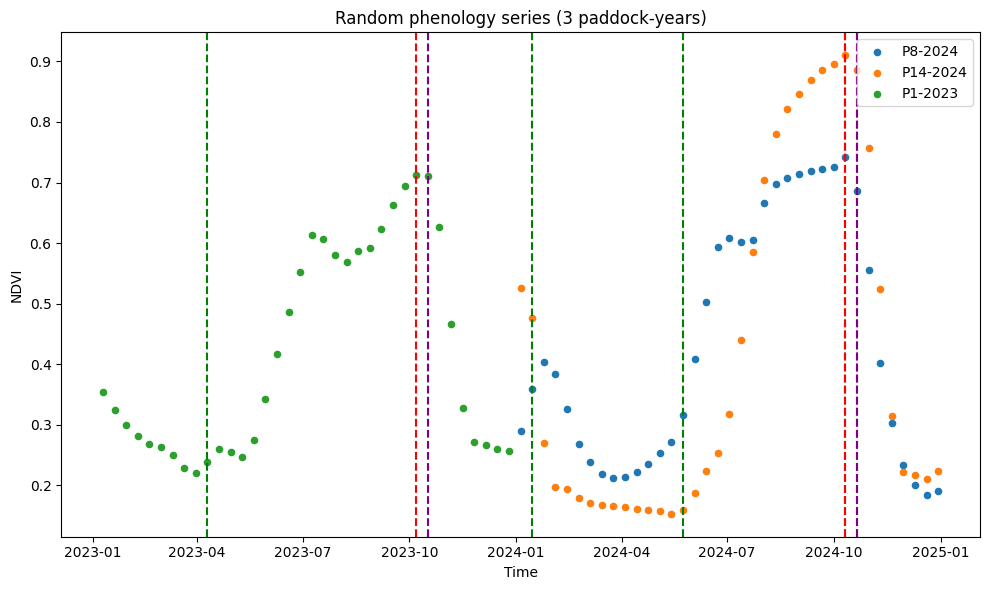

In [18]:

def plot_phenology_random(
    df: pd.DataFrame,
    ds_by_year: dict[int, xr.Dataset],
    var: str = "NDVI",
    N: int = 3,
    seed: int | None = None,
    unit_dim: str = "paddock",
    time_dim: str = "time"
):
    """
    Scatter-plot `var` time series for `N` random paddock-year entries,
    with vertical lines at SoS (green), PoS (red), and EoS (purple),
    and print number of peaks per series.
    """
    rng = np.random.default_rng(seed)
    # list of (paddock, year)
    pairs = list(zip(df['paddock'], df['year']))
    if N > len(pairs):
        raise ValueError("N exceeds number of paddock-year entries")
    indices = rng.choice(len(pairs), size=N, replace=False)

    plt.figure(figsize=(10, 6))
    for i in indices:
        pad, yr = pairs[i]
        ds = ds_by_year.get(yr)
        series = ds[var].sel({unit_dim: pad})
        times = series[time_dim].values
        values = series.values
        # print peaks
        n = int(df.loc[(df.paddock == pad) & (df.year == yr), 'n_peaks'])
        print(f"Paddock {pad}, {yr}: {n} peak(s)")
        # scatter plot
        plt.scatter(times, values, s=20, label=f"P{pad}-{yr}")
        # annotate vertical lines
        row = df[(df.paddock == pad) & (df.year == yr)].iloc[0]
        for metric, color in [('SoS', 'green'), ('PoS', 'red'), ('EoS', 'purple')]:
            day = int(row[metric])
            date = np.datetime64(f"{yr}-01-01") + np.timedelta64(day-1, 'D')
            plt.axvline(date, color=color, linestyle='--')

    plt.xlabel('Time')
    plt.ylabel(var)
    plt.title(f"Random phenology series ({N} paddock-years)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_phenology_random(df, ds_paddocks_resample_years)

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_variable_panels(df, ds_dict, variable):
    """
    Scatter-plots of `variable` for each paddock (rows) and year (columns),
    annotated with SoS, PoS, EoS, paddock ID, and n_peaks. 

    Panel size: 3″ wide by 2″ high; overall figsize = (3*cols, 2*rows).
    """
    years = sorted(ds_dict.keys())
    paddocks = sorted(df['paddock'].unique())
    n_rows, n_cols = len(paddocks), len(years)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4 * n_cols, 1.5 * n_rows),
                             squeeze=False)

    for i, paddock in enumerate(paddocks):
        for j, year in enumerate(years):
            ax = axes[i, j]
            ds_year = ds_dict[year]
            if str(paddock) not in ds_year['paddock'].values:
                ax.set_axis_off()
                continue

            da = ds_year[variable].sel(paddock=str(paddock))
            doy = ds_year['doy'].values

            # scatter time series
            ax.scatter(doy, da.values, s=10)

            # title for the top row
            if i == 0:
                ax.set_title(f"{year}", pad=8)

            row = df[(df['paddock'] == paddock) & (df['year'] == year)]
            if not row.empty:
                r = row.iloc[0]
                # colored vertical lines
                ax.axvline(r['SoS'], color='green', linestyle='--')
                ax.axvline(r['PoS'], color='blue', linestyle='-.')
                ax.axvline(r['EoS'], color='red', linestyle=':')

                # white box behind text
                bbox = dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round')
                ax.text(0.05, 0.9, f"Paddock {paddock}", transform=ax.transAxes, va='top', bbox=bbox)
                ax.text(0.05, 0.7, f"n_peaks: {int(r['n_peaks'])}", transform=ax.transAxes, va='top', bbox=bbox)
                if pd.notna(r.get('pred_crop', None)):
                    ax.text(0.95, 0.88, f"crop: {r['pred_crop']}",
                            transform=ax.transAxes, ha='right', va='top', bbox=bbox)

            # axis labels
            if j == 0:
                ax.set_ylabel(variable)
            ax.set_xlabel("DOY")

    fig.tight_layout()
    plt.show()

# Example usage:
# plot_variable_panels(df, ds_paddocks_resample_years, 'NDVI')




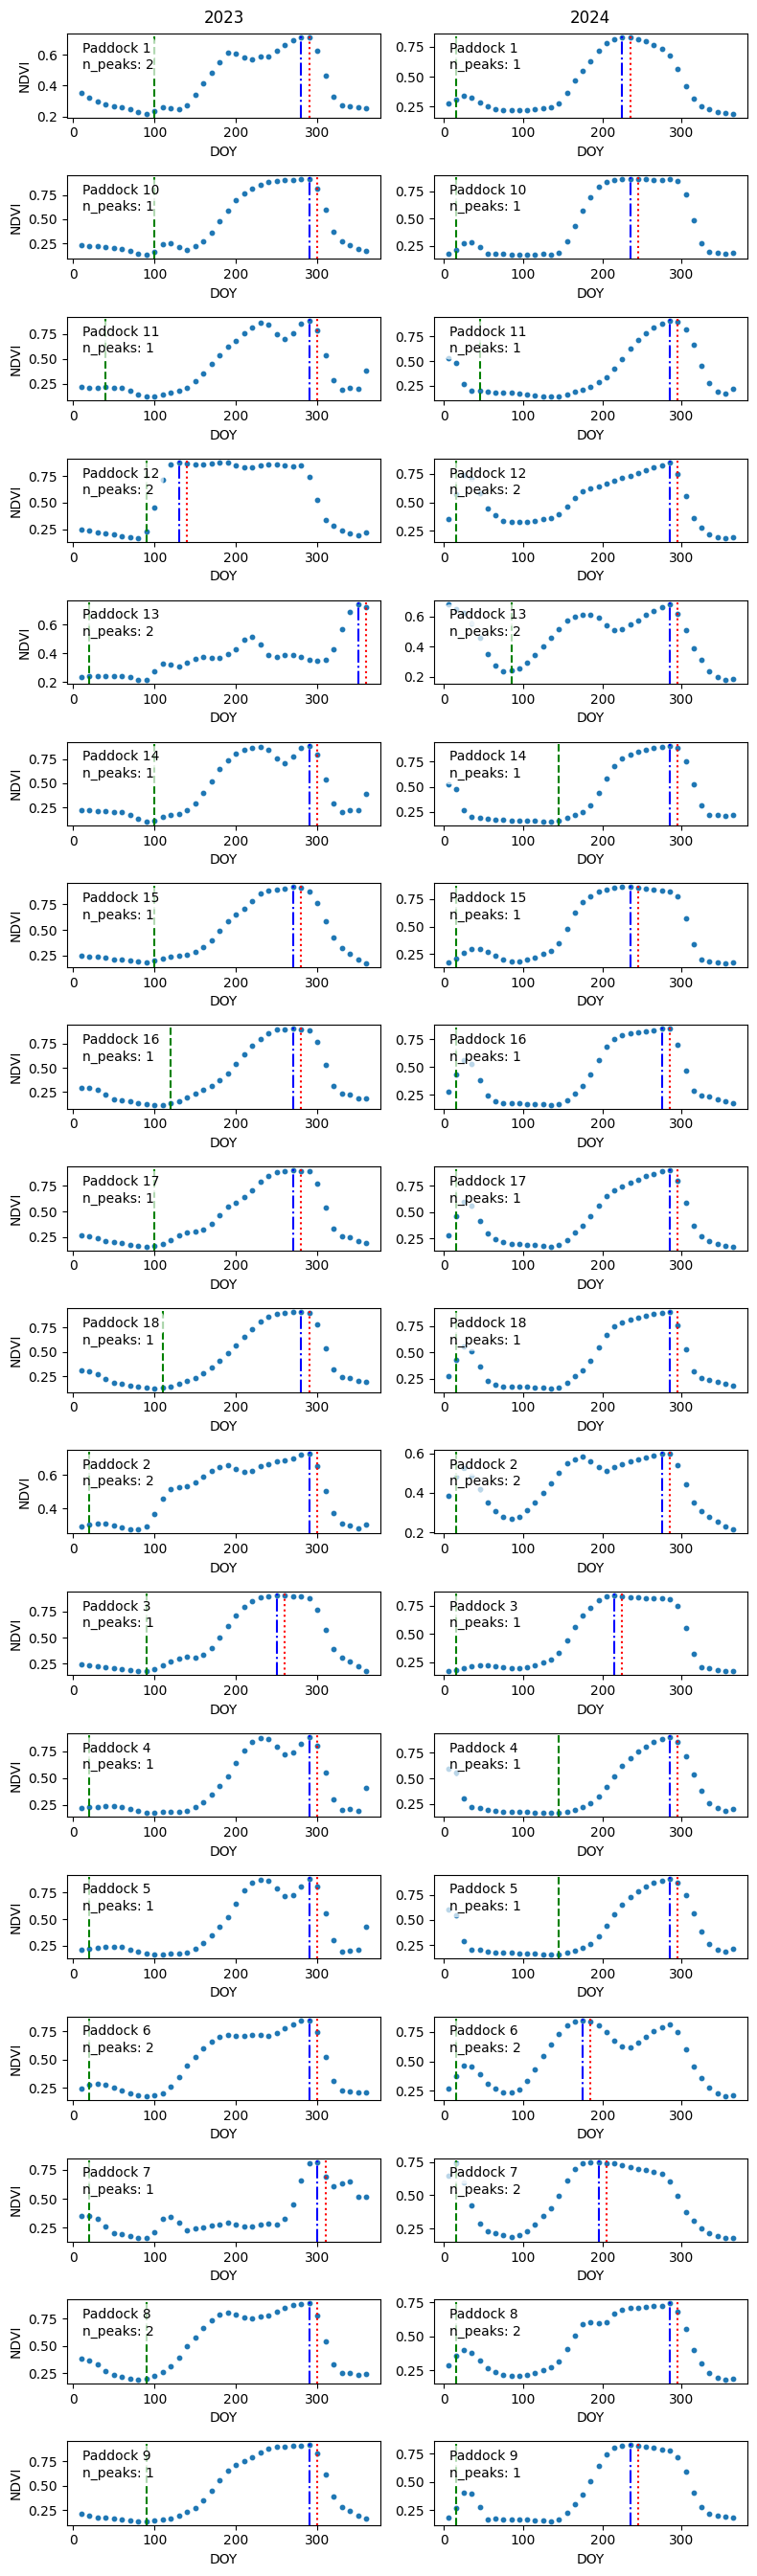

In [20]:
plot_variable_panels(df, ds_paddocks_resample_years, 'NDVI')

##  Plotting functions for another script

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap(ds, variable_name):
    """
    Plots a heatmap for the specified variable in the dataset.
    
    Parameters:
        ds (xarray.Dataset): Dataset with 'paddock' and 'time' as coordinates.
        variable_name (str): Name of the variable to plot (e.g., 'nbart_blue_median').
    """
    # Convert the DataArray into a pandas DataFrame
    # The index will be paddocks and columns will be time.
    df = ds[variable_name].to_pandas()
    
    # Format the dates as YYYY-MM-DD (assuming the columns are a DatetimeIndex)
    if isinstance(df.columns, pd.DatetimeIndex):
        df.columns = df.columns.strftime('%Y-%m-%d')
    
    plt.figure(figsize=(12, 8))
    
    # Plot the heatmap without annotations and with a shrunken colorbar.
    ax = sns.heatmap(df, cmap="viridis", annot=False, cbar_kws={"shrink": 0.5})
    
    # Set the colorbar title to the variable name.
    colorbar = ax.collections[0].colorbar
    colorbar.set_label(variable_name)
    
    # Set axis labels
    ax.set_xlabel("Observation Date")
    ax.set_ylabel("Paddock")
    
    # Rotate paddock (row) labels to be horizontal.
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    # No plot title is set.
    plt.show()

# Example usage:
# plot_heatmap(ds_paddocks, 'nbart_blue_median')

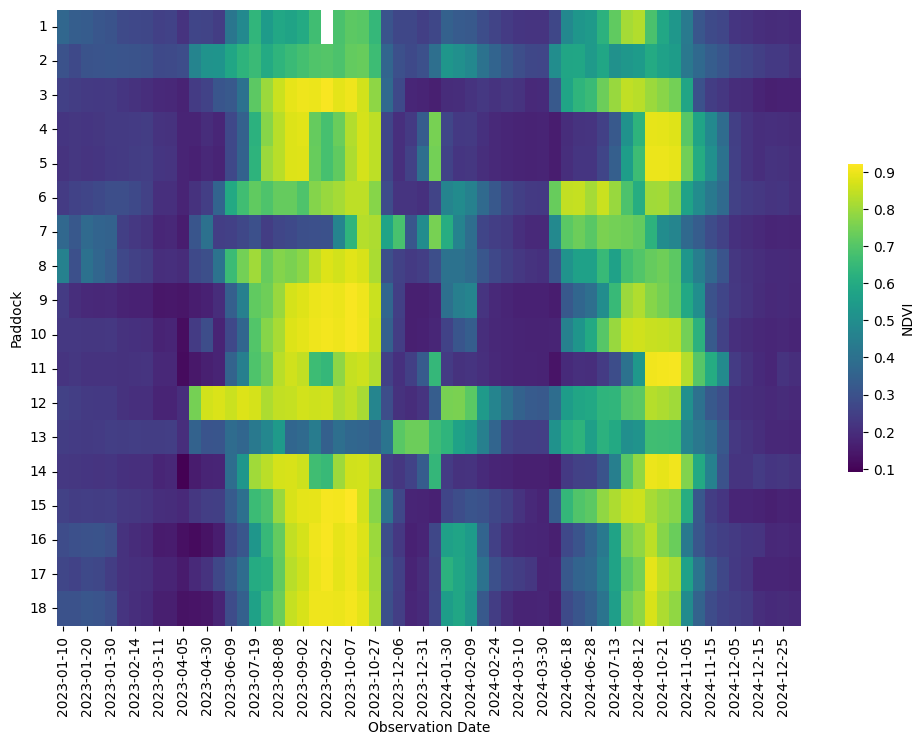

In [22]:
plot_heatmap(ds_paddocks, 'NDVI')

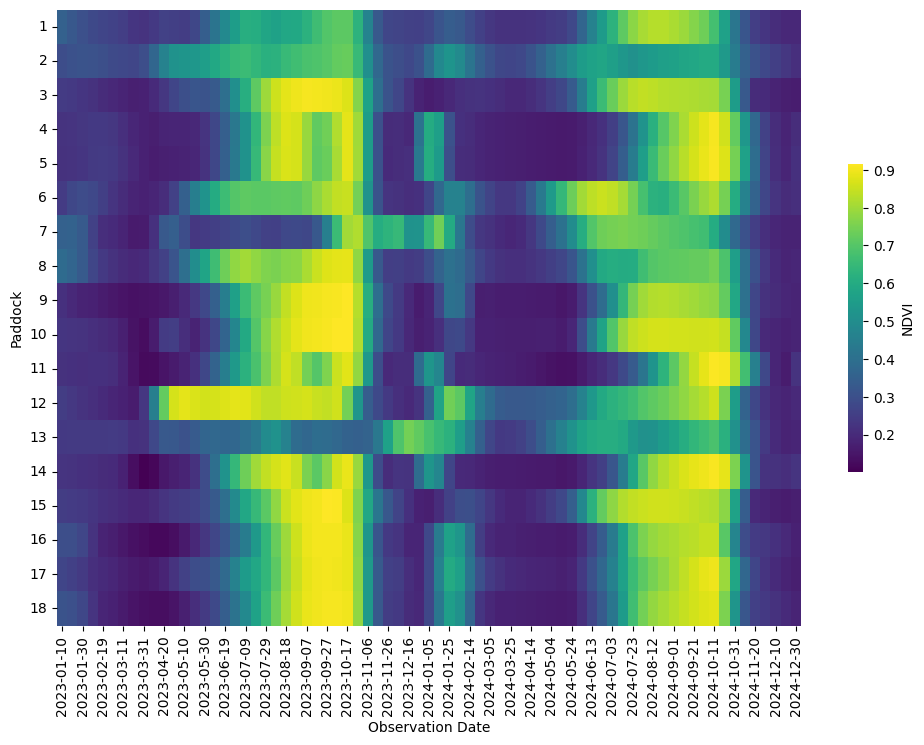

In [23]:
plot_heatmap(ds_paddocks_resample, 'NDVI')

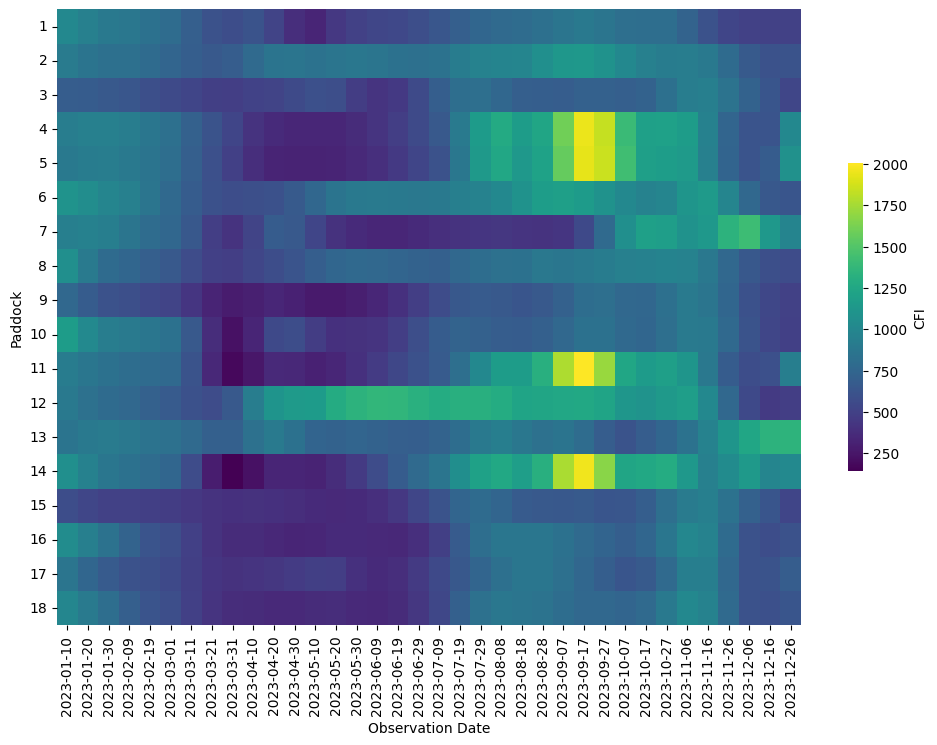

In [24]:
plot_heatmap(ds_paddocks_resample_years[2023], 'CFI')

In [25]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


def plot_gap_lengths_by_year(ds: xr.Dataset,
                             var: str = "nbart_red",
                             *,
                             unit_dim: str = "paddock",
                             time_dim: str = "time",
                             min_gap_days: int = 1,
                             bins: int | str = "auto",
                             figsize: tuple[int, int] = (6, 4),
                             show: bool = True) -> dict[int, list[int]]:
    """
    Histogram of calendar-day gaps between successive valid observations.

    • Left y-axis  : absolute count of gaps.
    • Right y-axis : count ÷ number-of-paddocks (tick labels rounded).

    A red dotted vertical line marks `min_gap_days`; x-axis spans [min, max].
    """
    if var not in ds.data_vars:
        raise KeyError(f"{var!r} not found in dataset.")

    da = ds[var]
    n_units = ds.dims[unit_dim]    # total paddocks

    def _gaps_in_days(times: np.ndarray) -> np.ndarray:
        if times.size < 2:
            return np.empty(0, dtype=int)
        deltas = np.diff(np.sort(times.astype("datetime64[D]")))
        return deltas.astype("timedelta64[D]").astype(int)

    gap_dict: dict[int, list[int]] = {}

    for yr, da_year in da.groupby(f"{time_dim}.year"):
        gaps_all: list[int] = []
        for unit in da_year[unit_dim]:
            times = da_year.sel({unit_dim: unit}).dropna(time_dim)[time_dim].values
            gaps_all.extend(_gaps_in_days(times))

        gap_dict[yr] = [g for g in gaps_all if g >= min_gap_days]

        if show:
            fig, ax = plt.subplots(figsize=figsize)

            # histogram
            counts, edges, _ = ax.hist(gaps_all, bins=bins,
                                       edgecolor="black", alpha=0.7)

            # secondary y-axis: same scale, labels = counts/n_units (rounded)
            ax2 = ax.twinx()
            ax2.set_ylim(ax.get_ylim())
            primary_ticks = ax.get_yticks()
            ax2.set_yticks(primary_ticks)
            ax2.set_yticklabels([str(int(round(y / n_units))) for y in primary_ticks])
            ax2.set_ylabel("gaps per paddock")

            # red dotted threshold
            ax.axvline(min_gap_days, color="red", linestyle="dotted",
                       linewidth=1.5, label=f"threshold = {min_gap_days} d")

            # axis limits
            if gaps_all:
                ax.set_xlim(min(gaps_all), max(gaps_all))
            else:
                ax.set_xlim(0, 1)

            ax.set_xlabel("gap length (days)")
            ax.set_ylabel("number of gaps")
            ax.set_title(f"{var} – gap lengths, {yr}")
            ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()

    return gap_dict



/jobfs/144414368.gadi-pbs/ipykernel_1449714/2260889710.py:27: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_units = ds.dims[unit_dim]    # total paddocks


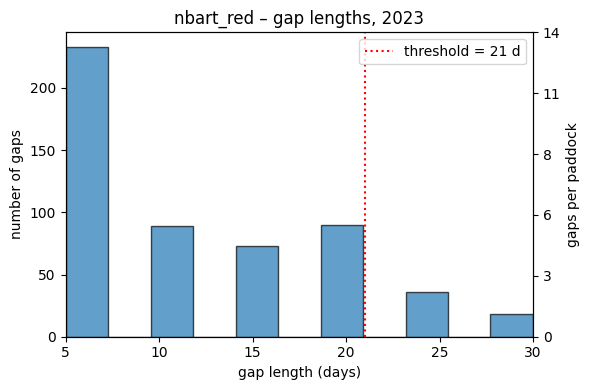

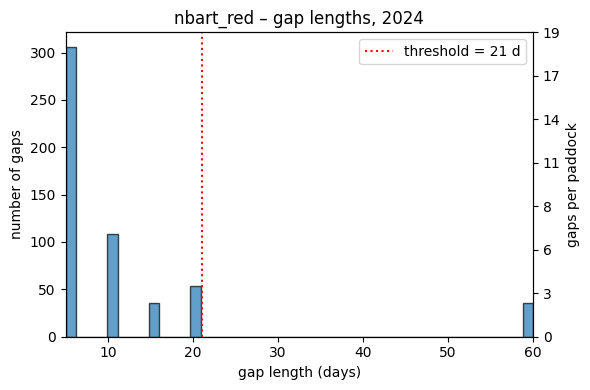

In [26]:
gap_stats = plot_gap_lengths_by_year(ds_paddocks,
                                     var="nbart_red",
                                     min_gap_days=21)
# Next time, the threshold should indicate a red dotted line, and the domain should cover min to max. 

In [27]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


def plot_random_paddock_series(ds: xr.Dataset,
                               var: str = "nbart_red",
                               N: int = 3,
                               seed: int | None = None,
                               unit_dim: str = "paddock",
                               time_dim: str = "time",
                               interval_days: int = 10):
    """
    Scatter-plot `var` vs. time for `N` random paddocks, with faint
    vertical lines every `interval_days` to highlight data gaps.
    """
    if var not in ds:
        raise KeyError(f"{var!r} not found in dataset.")

    rng = np.random.default_rng(seed)
    paddock_ids = ds[unit_dim].values
    if N > len(paddock_ids):
        raise ValueError("N exceeds number of paddocks.")
    chosen = rng.choice(paddock_ids, size=N, replace=False)

    # ── build the background grid of vertical lines ────────────────
    tmin = ds[time_dim].values.min().astype("datetime64[D]")
    tmax = ds[time_dim].values.max().astype("datetime64[D]")
    vlines = np.arange(tmin, tmax + np.timedelta64(interval_days, "D"),
                       np.timedelta64(interval_days, "D"))

    plt.figure(figsize=(8, 4))

    # draw grid first (low z-order so scatter sits on top)
    for v in vlines:
        plt.axvline(v, color="lightgray", linewidth=0.8, zorder=0)

    # ── scatter each sampled paddock ───────────────────────────────
    for pid in chosen:
        da = ds[var].sel({unit_dim: pid})
        plt.scatter(da[time_dim], da, s=15, label=f"{unit_dim} {pid}")

    plt.xlabel("Time")
    plt.ylabel(var)
    plt.title(f"{var} – {N} random paddocks")
    plt.legend()
    plt.tight_layout()
    plt.show()


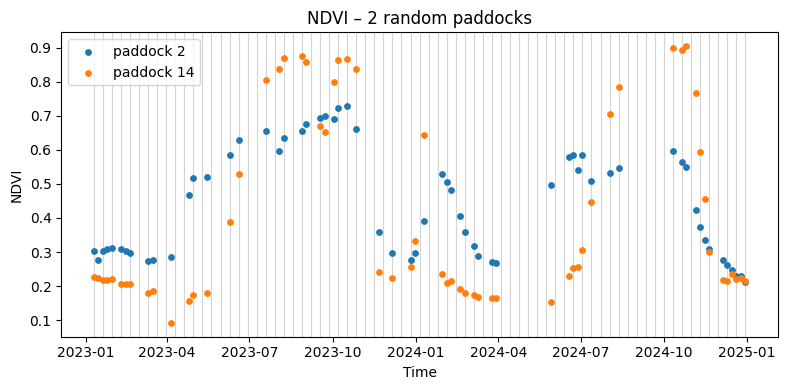

In [28]:
# plot nbart_red for 4 random paddocks
plot_random_paddock_series(ds_paddocks, var="NDVI", N=2, seed=42)

## Trying to run phenolpy directly:


In [30]:
import sys
sys.path.append('/g/data/xe2/John/Software/PhenoloPy/scripts')
import phenolopy

In [32]:
ds_paddocks_resample_years


{2023: <xarray.Dataset> Size: 84kB
 Dimensions:           (paddock: 18, time: 36)
 Coordinates:
   * paddock           (paddock) object 144B '1' '2' '3' '4' ... '16' '17' '18'
   * time              (time) datetime64[ns] 288B 2023-01-10 ... 2023-12-26
     spatial_ref       int32 4B 6933
     doy               (time) int64 288B 10 20 30 40 50 ... 320 330 340 350 360
 Data variables: (12/16)
     nbart_blue        (paddock, time) float64 5kB 720.5 725.4 ... 801.4 885.2
     nbart_green       (paddock, time) float64 5kB 1.017e+03 ... 1.192e+03
     nbart_red         (paddock, time) float64 5kB 1.451e+03 ... 1.653e+03
     nbart_red_edge_1  (paddock, time) float64 5kB 1.845e+03 ... 1.844e+03
     nbart_red_edge_2  (paddock, time) float64 5kB 2.409e+03 ... 2.017e+03
     nbart_red_edge_3  (paddock, time) float64 5kB 2.836e+03 ... 2.306e+03
     ...                ...
     bg                (paddock, time) float64 5kB 0.03425 0.03176 ... 0.09632
     pv                (paddock, time) float6

In [56]:
# Choose which variable to use for phenology metrix extraction

which_var = 'NDVI'

## have to drop one of "time" or "doy" from the xarray. 

# # drop doy:
ds_veg_index = (
    ds_paddocks_resample_years[2023][[which_var]]
    .rename({which_var: "veg_index"})
    .drop_vars("doy")
)

print(ds_veg_index['veg_index'])

<xarray.DataArray 'veg_index' (paddock: 18, time: 36)> Size: 5kB
array([[0.35324358, 0.32363159, 0.2996293 , 0.28069173, 0.26840092,
        0.26304261, 0.24945602, 0.22795687, 0.2198319 , 0.23753071,
        0.25981014, 0.25464534, 0.24647294, 0.27438227, 0.34196499,
        0.41690893, 0.48529444, 0.55137495, 0.61411057, 0.60654383,
        0.5807296 , 0.56790422, 0.58697706, 0.59106809, 0.62362737,
        0.66248523, 0.6939039 , 0.71191236, 0.71064485, 0.62656193,
        0.46700626, 0.32681344, 0.2719917 , 0.2672098 , 0.25909743,
        0.25608398],
       [0.29003044, 0.30434158, 0.31032037, 0.30673973, 0.2971592 ,
        0.28532651, 0.27748098, 0.2724765 , 0.29527193, 0.36707047,
        0.46051107, 0.51372496, 0.52566124, 0.53371707, 0.55396253,
        0.58900758, 0.62336038, 0.64614591, 0.65707394, 0.63714996,
        0.62008819, 0.62223179, 0.65107072, 0.66624463, 0.68374422,
        0.68985135, 0.70035564, 0.72110005, 0.72696069, 0.65077184,
        0.50456514, 0.37303622

In [54]:
# da_veg_index = (
#     ds_paddocks_resample_years[2023]
#     .rename({which_var: "veg_index"})
#     .set_index(time="doy")        # make doy the new index for the time dimension
#     ["veg_index"]                 # pull out the DataArray
#     #.rename({"time": "doy"})      # rename that index-dimension to "doy"
# )
# print(da_veg_index)

<xarray.DataArray 'veg_index' (paddock: 18, time: 36)> Size: 5kB
array([[0.35324358, 0.32363159, 0.2996293 , 0.28069173, 0.26840092,
        0.26304261, 0.24945602, 0.22795687, 0.2198319 , 0.23753071,
        0.25981014, 0.25464534, 0.24647294, 0.27438227, 0.34196499,
        0.41690893, 0.48529444, 0.55137495, 0.61411057, 0.60654383,
        0.5807296 , 0.56790422, 0.58697706, 0.59106809, 0.62362737,
        0.66248523, 0.6939039 , 0.71191236, 0.71064485, 0.62656193,
        0.46700626, 0.32681344, 0.2719917 , 0.2672098 , 0.25909743,
        0.25608398],
       [0.29003044, 0.30434158, 0.31032037, 0.30673973, 0.2971592 ,
        0.28532651, 0.27748098, 0.2724765 , 0.29527193, 0.36707047,
        0.46051107, 0.51372496, 0.52566124, 0.53371707, 0.55396253,
        0.58900758, 0.62336038, 0.64614591, 0.65707394, 0.63714996,
        0.62008819, 0.62223179, 0.65107072, 0.66624463, 0.68374422,
        0.68985135, 0.70035564, 0.72110005, 0.72696069, 0.65077184,
        0.50456514, 0.37303622

In [35]:
# Calculate number of peaks using phenolopy:
da_num_seasons = phenolopy.calc_num_seasons(ds=ds_veg_index)

print(da_num_seasons.values)

Beginning calculation of number of seasons.
> Calculating number of seasons.
> Success!

[2 2 1 1 1 2 1 2 1 1 1 2 2 1 1 1 1 1]


In [63]:
import importlib
xr = importlib.reload(xr)

_real_merge = xr.merge

#  A safe override that drops any incoming compat first:
def _override_merge(objs, *args, **kwargs):
    kwargs.pop("compat", None)
    return _real_merge(objs, compat="override", **kwargs)

# Monkey-patch phenolopy’s xarray reference:
# this was required because of the way that phenology uses xarray.merge()
phenolopy.xr.merge = _override_merge

# run phenology.calc_phenometrics
# required input is a data array with time encoded as datetime64. It will give outputs as doy. 
ds_phenos = phenolopy.calc_phenometrics(
    da=ds_veg_index['veg_index'],
    peak_metric="pos",
    base_metric="bse",
    method="first_of_slope",
    factor=0.5,
    thresh_sides="two_sided",
    abs_value=0,
)

# Restore the original
phenolopy.xr.merge = _real_merge



Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> No CRS metadata found. Returning None.

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of valley of season (vos) values and times.
> Calculating valley of season (vos) values.
> Calculating valley of season (vos) times.
> Success!

Beginning calculation of middle of season (mos) values (times not possible).
> Calculating middle of season (mos) values.
> Success!

Beginning calculation of base (bse) values (times not possible).
> Calculating base (bse) values.
> Success!

Beginning calculation of amplitude of season (aos) values (times not possible).
> Calculating amplitude of season (aos) values.
> Success!

Beginning calculation of start of season (sos) values and time

In [64]:
phenos_df = ds_phenos.drop_vars(["spatial_ref", "time"]).to_dataframe().reset_index()

phenos_df

,paddock,pos_values,pos_times,mos_values,vos_values,vos_times,bse_values,aos_values,sos_values,sos_times,eos_values,eos_times,los_values,roi_values,rod_values,lios_values,sios_values,liot_values,siot_values
0,1,0.711912,280.0,0.656595,0.219832,90.0,0.237958,0.473954,0.219832,90.0,0.256084,360.0,270.0,0.002590,0.005698,12.584846,6.041003,14.674277,6.345749
1,2,0.726961,290.0,0.674233,0.272476,80.0,0.275889,0.451072,0.272476,80.0,0.295859,340.0,260.0,0.002164,0.008622,14.891521,7.442517,17.250004,7.593888
2,3,0.905892,250.0,0.870142,0.175053,80.0,0.177871,0.728021,0.176686,90.0,0.180690,360.0,270.0,0.004558,0.006593,14.884357,9.992891,16.443499,10.217998
3,4,0.884405,290.0,0.826199,0.171344,100.0,0.181941,0.702464,0.171344,100.0,0.200772,330.0,230.0,0.003753,0.017091,12.488567,8.121972,14.939437,8.571486
4,5,0.882725,290.0,0.826242,0.166846,100.0,0.183269,0.699457,0.172879,110.0,0.199691,330.0,220.0,0.003944,0.017076,12.305003,8.089826,14.971747,8.557347
5,6,0.848121,290.0,0.772881,0.176319,90.0,0.192455,0.655665,0.176319,90.0,0.208592,350.0,260.0,0.003359,0.010659,14.624879,9.428589,16.562397,9.826465
6,7,0.819106,300.0,0.757672,0.162294,80.0,0.339535,0.479571,0.164169,90.0,0.516776,350.0,260.0,0.003119,0.006047,10.692416,1.524976,12.819984,0.936266
7,8,0.887402,290.0,0.819907,0.193059,80.0,0.216030,0.671372,0.198820,90.0,0.239001,350.0,260.0,0.003443,0.010807,16.005342,10.172539,18.139103,10.578061
8,9,0.914614,290.0,0.867595,0.140109,80.0,0.151384,0.763229,0.140786,90.0,0.162659,360.0,270.0,0.003869,0.010742,14.465259,10.302192,15.728869,10.430421
9,10,0.916201,290.0,0.870874,0.128296,90.0,0.149557,0.766644,0.128296,90.0,0.170817,360.0,270.0,0.003940,0.010648,14.238577,10.125766,15.719210,10.484724


In [77]:
import pandas as pd
import xarray as xr
import phenolopy
import importlib
from contextlib import contextmanager

# Reload xarray to ensure a clean state
xr = importlib.reload(xr)

# Backup the original merge
_real_merge = xr.merge

@contextmanager
def override_xr_merge():
    """
    Context manager to temporarily override xarray.merge to use compat='override'.
    """
    # Define the override function
    def _override_merge(objs, *args, **kwargs):
        kwargs.pop("compat", None)
        return _real_merge(objs, compat="override", **kwargs)
    
    # Patch phenolopy's xarray reference
    phenolopy.xr.merge = _override_merge
    try:
        yield
    finally:
        # Restore the original merge
        phenolopy.xr.merge = _real_merge

def process_phenology(ds_yearly: dict, which_var: str) -> dict:
    """
    For each year in ds_yearly, computes the number of seasons and phenology metrics,
    returning a dict of pandas DataFrames (one per year).

    Parameters
    ----------
    ds_yearly : dict
        Mapping from year (int) to xarray.Dataset containing paddock time series.
    which_var : str
        Name of the data variable to process (e.g. 'NDVI').

    Returns
    -------
    dict of pd.DataFrame
        One DataFrame per year, indexed by paddock, with phenology metrics and num_seasons.
    """
    results = {}
    for year, ds in ds_yearly.items():
        # 1) Extract veg_index and drop doy
        ds_veg = (
            ds[[which_var]]
            .rename({which_var: "veg_index"})
            .drop_vars("doy")
        )
        
        # 2) Compute number of seasons per paddock
        da_num_seasons = phenolopy.calc_num_seasons(ds=ds_veg)
        
        # 3) Compute phenometrics with monkey-patched merge
        with override_xr_merge():
            ds_phenos = phenolopy.calc_phenometrics(
                da=ds_veg["veg_index"],
                peak_metric="pos",
                base_metric="bse",
                method="seasonal_amplitude",
                factor=0.05,
                thresh_sides="two_sided",
                abs_value=0,
            )
        
        # 4) Convert to DataFrame
        phenos_df = (
            ds_phenos
            .drop_vars(["spatial_ref", "time"])
            .to_dataframe()
            .reset_index()
        )
        
        # 5) Insert num_peaks column
        phenos_df["num_peaks"] = da_num_seasons.values
        
        # Store
        results[year] = phenos_df

    return results

# Example usage:
# phenology_results = process_phenology(ds_paddocks_resample_years, which_var="NDVI")
# Display the DataFrame for the first year
# import ace_tools as tools; tools.display_dataframe_to_user("Phenology 2023", phenology_results[2023])



### phenolopy parameter selection:
from https://github.com/lewistrotter/PhenoloPy/blob/main/scripts/phenolopy.py

    peak_metric: str
        Sets the highest value for each pixel timeseries to use for calculations that rely on 
        the highest value. Can be either pos (peak of season), which is the single highest
        value in the whole timeseries per pixel, or mos (middle of season), which is the mean 
        of the highest vales in top 90 percentile. Default is pos.
    base_metric: str
        Sets the lowest value for each pixel timeseries to use for calculations that rely on 
        the lowest value. Can be either vos (valley of season), which is the lowest possible
        value in the whole timeseries per pixel, or bse (base), which is the mean of the min
        value on the left and right slopes of the time series. Default is bse.
    method: str
        Sets the method used to determine pos (peak of season) and eos (end of season). Can be
        first_of_slope, median_of_slope, seasonal_amplitude, absolute_value, relative_amplitude,
        or stl_trend. See the get_pos and/or get_eos methods for more information.
    factor: float (>=0 and <=1)
        A float value between 0 and 1 which is used to increase or decrease the amplitude
        threshold for the get_pos and get_eos seasonal_amplitude method. A factor closer 
        to 0 results in start of season nearer to min value, a factor closer to 1 results in 
        start of season closer to peak of season.
    thresh_sides: str
        A string indicating whether the sos value threshold calculation should be the min 
        value of left slope (one_sided) only, or use the bse/vos value (two_sided) calculated
        earlier. Default is two_sided, as per TIMESAT 3.3. That said, one_sided is potentially
        more robust.
    abs_value: float
        For absolute_value method only. Defines the absolute value in units of the vege index to
        which sos is defined. The part of the vege slope that the absolute value hits will be the
        sos value and time.   

In [78]:
phenology_results = process_phenology(ds_paddocks_resample_years, which_var="NDVI")


Beginning calculation of number of seasons.
> Calculating number of seasons.
> Success!

Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> No CRS metadata found. Returning None.

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of valley of season (vos) values and times.
> Calculating valley of season (vos) values.
> Calculating valley of season (vos) times.
> Success!

Beginning calculation of middle of season (mos) values (times not possible).
> Calculating middle of season (mos) values.
> Success!

Beginning calculation of base (bse) values (times not possible).
> Calculating base (bse) values.
> Success!

Beginning calculation of amplitude of season (aos) values (times not possible).
> Calculating amplitude of season

In [68]:
#phenology_results

{2023:    paddock  pos_values  pos_times  mos_values  vos_values  vos_times  \
 0        1    0.711912      280.0    0.656595    0.219832       90.0   
 1        2    0.726961      290.0    0.674233    0.272476       80.0   
 2        3    0.905892      250.0    0.870142    0.175053       80.0   
 3        4    0.884405      290.0    0.826199    0.171344      100.0   
 4        5    0.882725      290.0    0.826242    0.166846      100.0   
 5        6    0.848121      290.0    0.772881    0.176319       90.0   
 6        7    0.819106      300.0    0.757672    0.162294       80.0   
 7        8    0.887402      290.0    0.819907    0.193059       80.0   
 8        9    0.914614      290.0    0.867595    0.140109       80.0   
 9       10    0.916201      290.0    0.870874    0.128296       90.0   
 10      11    0.880739      290.0    0.823334    0.121900       90.0   
 11      12    0.882520      130.0    0.838256    0.162630       80.0   
 12      13    0.743158      350.0    0.72329

In [75]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_paddock_year_phenology(phenology_results: dict,
                                ds_paddocks_resample_years: dict,
                                variable: str):
    """
    For each paddock (rows) and year (columns), scatter-plot the time series of `variable`
    from ds_paddocks_resample_years, and annotate with SoS, PoS, EoS, paddock ID, and num_seasons
    from phenology_results.

    Parameters
    ----------
    phenology_results : dict[int, pd.DataFrame]
        Mapping year -> DataFrame with columns including:
          - 'paddock' (as string or int),
          - 'sos_times', 'pos_times', 'eos_times',
          - 'num_seasons', ...
    ds_paddocks_resample_years : dict[int, xr.Dataset]
        Mapping year -> Dataset containing time series with coords:
          - paddock (object/string),
          - time (datetime64),
          - doy (int day-of-year)
          - data variables including `variable`.
    variable : str
        Name of the data variable to plot (e.g. 'NDVI').

    Returns
    -------
    None (shows a matplotlib figure)
    """
    years = sorted(ds_paddocks_resample_years.keys())
    
    # paddock IDs from first year's dataset (assuming same for all years)
    paddocks = list(ds_paddocks_resample_years[years[0]].paddock.values)
    
    n_rows, n_cols = len(paddocks), len(years)
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4 * n_cols, 1.5 * n_rows),
                             squeeze=False)
    
    for i, paddock in enumerate(paddocks):
        for j, year in enumerate(years):
            ax = axes[i, j]
            ds_year = ds_paddocks_resample_years[year]
            df_year = phenology_results[year]
            
            # if this paddock isn't in this year's dataset, hide axis
            if str(paddock) not in ds_year.paddock.values:
                ax.set_axis_off()
                continue
            
            # get the DataArray and DOY
            da = ds_year[variable].sel(paddock=str(paddock))
            doy = ds_year['doy'].values
            
            # scatter time series
            ax.scatter(doy, da.values, s=10)
            
            # title only on top row
            if i == 0:
                ax.set_title(f"{year}", pad=8)
            
            # annotation row for this paddock-year
            row = df_year[df_year['paddock'].astype(str) == str(paddock)]
            if not row.empty:
                r = row.iloc[0]
                # vertical lines
                ax.axvline(r['sos_times'], color='green', linestyle='--')
                ax.axvline(r['pos_times'], color='blue', linestyle='-.')
                ax.axvline(r['eos_times'], color='red', linestyle=':')
                
                # text box
                bbox = dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round')
                ax.text(0.05, 0.9, f"Paddock {paddock}", transform=ax.transAxes,
                        va='top', bbox=bbox)
                ax.text(0.05, 0.7, f"n_peaks: {int(r['num_peaks'])}", transform=ax.transAxes,
                        va='top', bbox=bbox)

            # axis labels on left and bottom
            if j == 0:
                ax.set_ylabel(variable)
            ax.set_xlabel("DOY")
    
    fig.tight_layout()
    plt.show()

# Example:
# plot_paddock_year_phenology(phenology_results, ds_paddocks_resample_years, variable="NDVI")


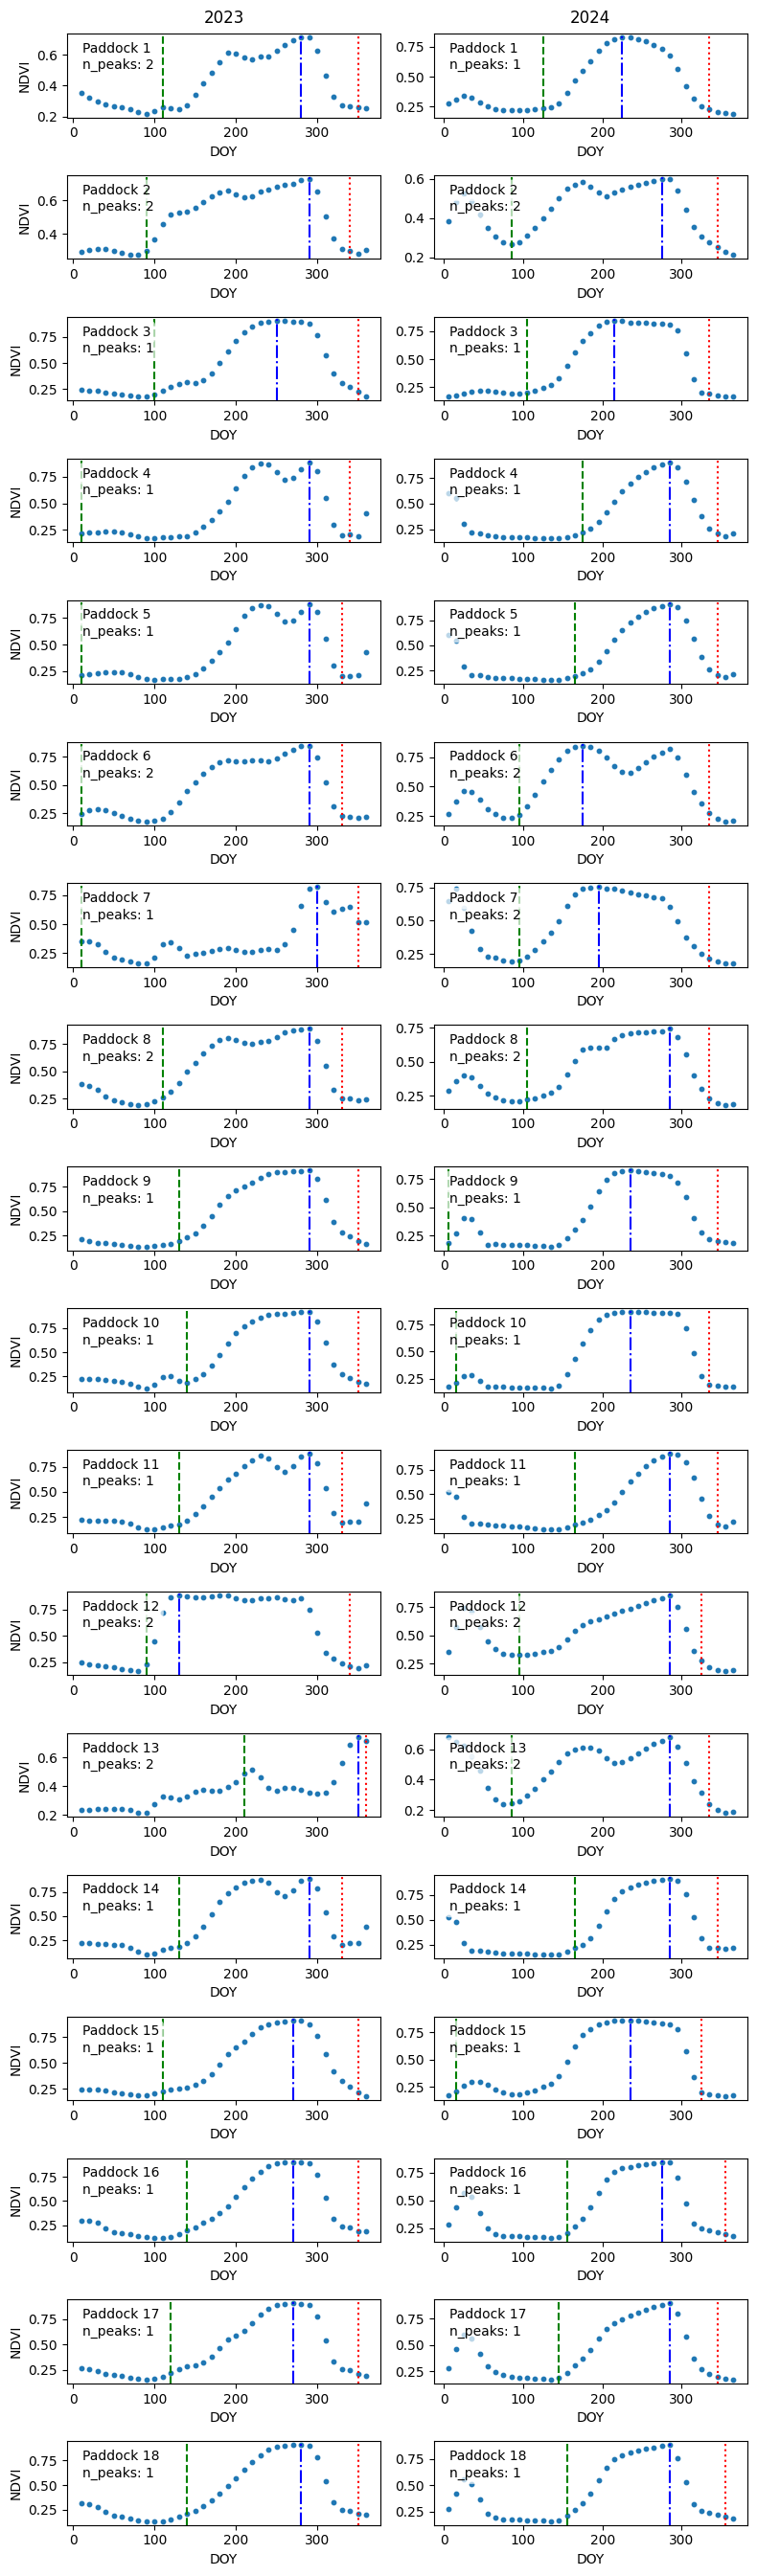

In [79]:
plot_paddock_year_phenology(phenology_results, ds_paddocks_resample_years, variable="NDVI")

In [89]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

def plot_paddock_year_phenology_with_raw(phenology_results: dict,
                                         ds_paddocks_resample_years: dict,
                                         ds_paddocks: xr.Dataset,
                                         variable: str):
    """
    Overlay raw and interpolated data as specified:
    - Interpolated (smoothed) series: blue circles with solid white centers.
    - Raw series: blue circles with solid blue centers, plotted on top.

    Parameters
    ----------
    phenology_results : dict[int, pd.DataFrame]
        Year -> DataFrame with 'paddock', 'sos_times', 'pos_times', 'eos_times', 'num_seasons'.
    ds_paddocks_resample_years : dict[int, xr.Dataset]
        Year -> Dataset with interpolated time series and 'doy'.
    ds_paddocks : xr.Dataset
        Raw Dataset with dims ('time', 'paddock') and datetime64 time.
    variable : str
        Variable name to plot (e.g., 'NDVI').
    """
    years = sorted(ds_paddocks_resample_years.keys())
    paddocks = list(ds_paddocks_resample_years[years[0]].paddock.values)
    n_rows, n_cols = len(paddocks), len(years)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4 * n_cols, 1.5 * n_rows),
                             squeeze=False)

    for i, paddock in enumerate(paddocks):
        for j, year in enumerate(years):
            ax = axes[i, j]
            df_year = phenology_results[year]
            ds_year = ds_paddocks_resample_years[year]

            # Plot interpolated (smoothed) series first: blue edge, white fill
            da_res = ds_year[variable].sel(paddock=str(paddock))
            res_doy = ds_year['doy'].values
            ax.scatter(res_doy, da_res.values,
                       facecolors='white', edgecolors='blue',
                       s=20, label='interpolated')

            # Raw subset for this year and paddock
            ds_raw_year = ds_paddocks.sel(
                time=slice(f"{year}-01-01", f"{year}-12-31")
            )
            da_raw = ds_raw_year[variable].sel(paddock=str(paddock))
            raw_doy = da_raw['time'].dt.dayofyear.values

            # Plot raw points on top: solid blue circles
            ax.scatter(raw_doy, da_raw.values,
                       color='blue', s=20, label='raw')

            # Titles and labels
            if i == 0:
                ax.set_title(f"{year}", pad=8)
            if j == 0:
                ax.set_ylabel(variable)
            ax.set_xlabel("DOY")

            # Annotate phenology lines
            row = df_year[df_year['paddock'].astype(str) == str(paddock)]
            if not row.empty:
                r = row.iloc[0]
                ax.axvline(r['sos_times'], color='green', linestyle='--', label='SoS')
                ax.axvline(r['pos_times'], color='blue', linestyle='-.', label='PoS')
                ax.axvline(r['eos_times'], color='red', linestyle=':', label='EoS')

                bbox = dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round')
                ax.text(0.05, 0.9, f"Paddock {paddock}", transform=ax.transAxes,
                        va='top', bbox=bbox)
                ax.text(0.05, 0.7, f"n_peaks: {int(r['num_peaks'])}", transform=ax.transAxes,
                        va='top', bbox=bbox)

    # Add a single legend
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4)

    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


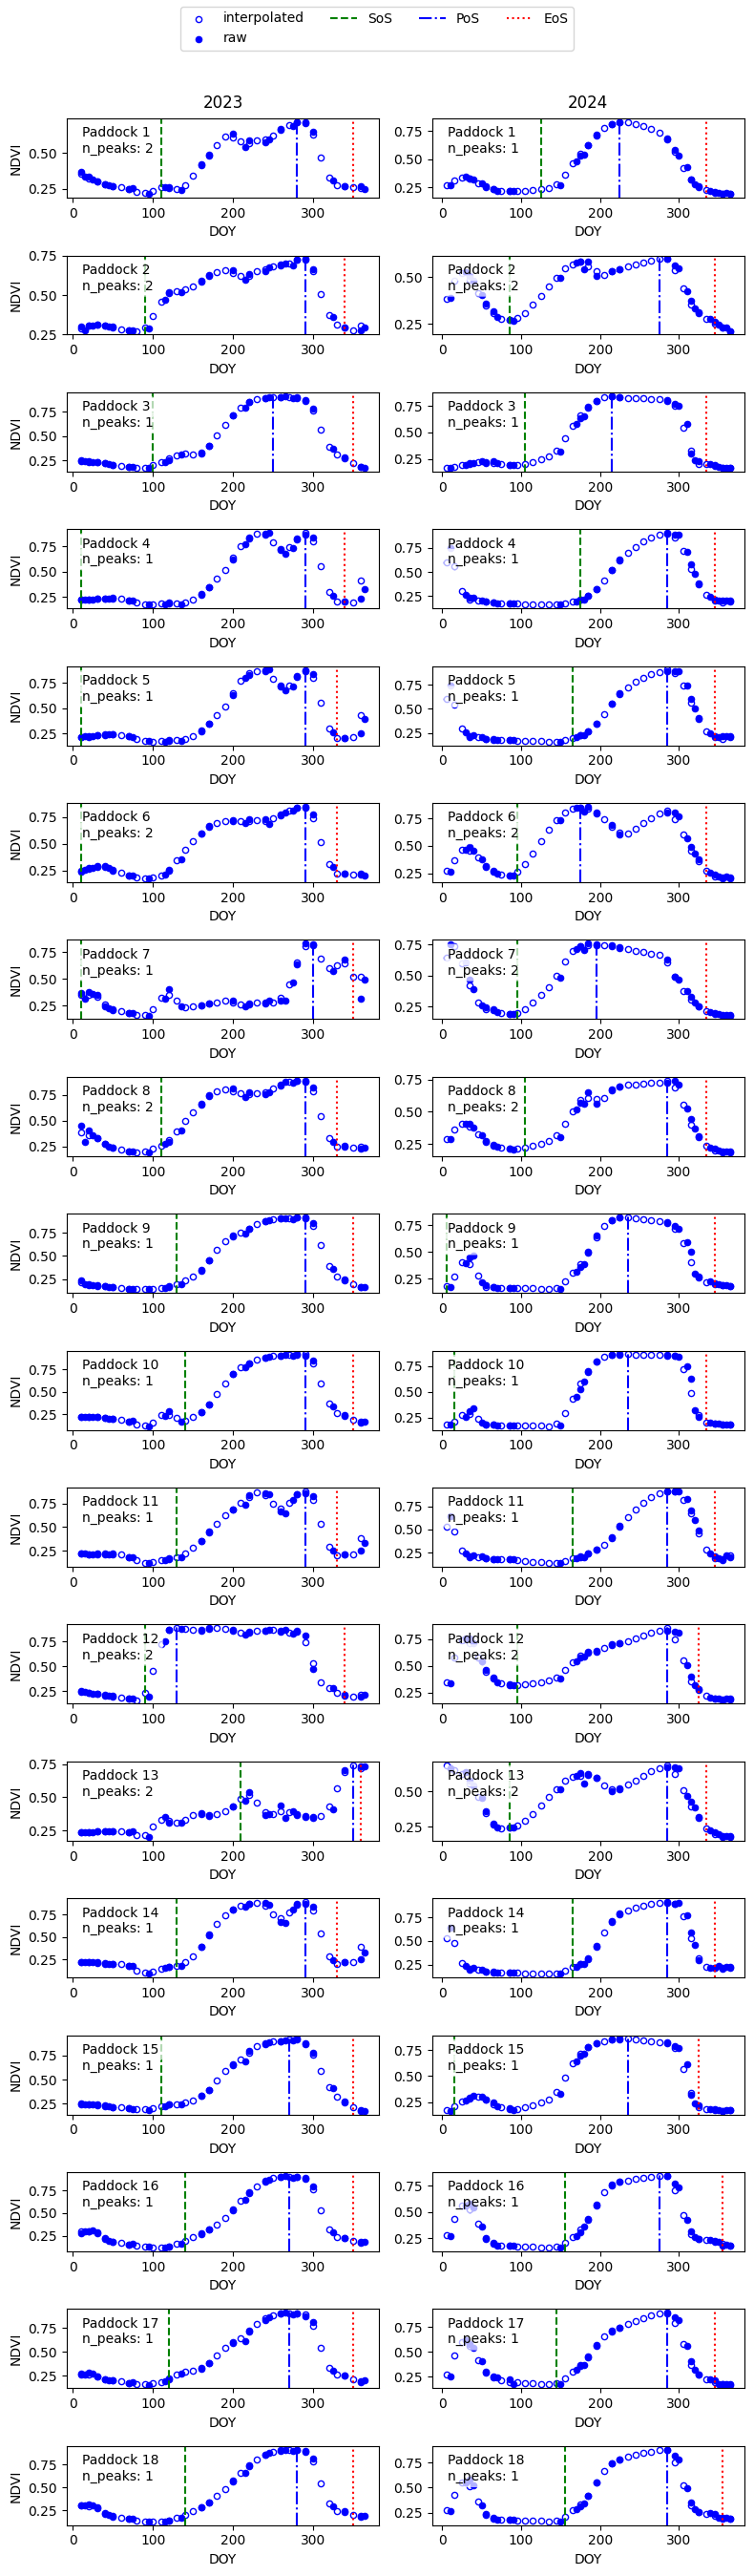

In [90]:
plot_paddock_year_phenology_with_raw(
    phenology_results,
    ds_paddocks_resample_years,
    ds_paddocks,
    variable="NDVI"
)